# Model Testing and Validation

## Methods of testing
Consider a hypothetical data set with information on 1000 patients. 
1. **Hold out validation**: build a model from the first 500 patients and test on the next 500.
2. **Ten fold cross validation**:  build a model from the first 900 patients and test on the next 100, then build a model using data from patients 101-1000 and test on the first 100, and so on until you cover the whole data set.
3. **Re-substitution (weakest method)**: train on data from all 1000 patients and test on the same data set.
4. **Independent validation (strongest)**: use data from a different study to test the model.

## Metrics for evaluating accuracy
Continuous response data (e.g. levels of blood glucose)
- **Pearson's Correlation**: measures the strength and direction of a linear relationship between two variables.
- **Rank Correlation**: measures the strength and direction of a monotonic relationship between two variables.
- **Root Mean Square Error (RMSE)**: measures the standard deviation of the residuals. Residuals represent the difference between predicted values and observed values. 
$$RMSE=\sqrt{\frac{\sum\limits_{i=1}^{n}(\hat{y_i}-y_i)^2}{n}}$$
Discrete data sets (e.g. Normal vs Diabetes)
- **Accuracy**: the ratio of correct predictions to the total observations.
- **Precision**: the ratio of true positives to the total predicted positives.
- Recall: the ratio of true positives to the total actual positives. Also known as sensitivity. 
There is no single metric that gives an overall picture of accuracy. It is necessary to use a range of metrics to get a holistic picture.

## Multinomial linear regression model
Consider BMI to be a function of age, sex, glucose, cholesterol, and systolic blood pressure. How can we use these variables to determine BMI?

Recall from last lecture that we can use the `polyfit` function to create a linear regression model. Start by reading in the Framingham data set and extracting the explanatory and response variables into a new table. (Hint: When using `polyfit` with a table, the last column in the table is assumed to be the response variable.) 


In [ ]:
!gdown --id 1OnIYNtdVIVIgrxdDkL3L0chpG8DpWTjz

Downloading...
From: https://drive.google.com/uc?id=1OnIYNtdVIVIgrxdDkL3L0chpG8DpWTjz
To: /content/fram.txt
100% 1.46M/1.46M [00:00<00:00, 46.4MB/s]


In [ ]:
 %matplotlib inline

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from numpy import NaN
from numpy.polynomial.polynomial import polyfit
import sklearn.metrics
from sklearn.linear_model import LogisticRegression
from statsmodels.discrete.discrete_model import MNLogit
import statsmodels.api as sm
import scipy.stats as stat
from statsmodels.tools.tools import add_constant
from statsmodels.formula.api import mnlogit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
from scipy.stats import zscore
from scipy.spatial.distance import pdist

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
fram = pd.read_csv("fram.txt", delimiter=",")
fram_revised = fram.loc[:,["AGE","SEX","GLUCOSE","TOTCHOL","SYSBP","BMI"]].dropna()
fram_revised

,AGE,SEX,GLUCOSE,TOTCHOL,SYSBP,BMI
0,39,1,77.0,195.0,106.0,26.97
2,46,2,76.0,250.0,121.0,28.73
3,52,2,86.0,260.0,105.0,29.43
4,58,2,71.0,237.0,108.0,28.50
5,48,1,70.0,245.0,127.5,25.34
...,...,...,...,...,...,...
11620,58,2,79.0,265.0,140.0,22.55
11621,40,1,72.0,185.0,141.0,25.60
11623,52,1,72.0,153.0,143.0,25.74
11624,39,2,80.0,196.0,133.0,20.91


Now create the linear regression model. 


In [ ]:
XY = fram_revised.values
X = XY[:, :-1]
X_ = add_constant(X)
Y = XY[:, -1].reshape(-1)
model = sm.OLS(Y, X_)
BMI_model = model.fit()
BMI_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     189.6
Date:                Thu, 06 May 2021   Prob (F-statistic):          1.53e-193
Time:                        19:00:19   Log-Likelihood:                -27755.
No. Observations:               10021   AIC:                         5.552e+04
Df Residuals:                   10015   BIC:                         5.557e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.8170      0.340     58.290      0.000      19.151      20.483
x1            -0.0270      0.004     -6.076      0.000      -0.036      -0.018
x2            -0.7705      0.078     -9.822      0.000      -0.924      -0.617
x3             0.0078      0.002      4.952      0.000       0.005       0.011
x4             0.0053      0.001      6.028      0.000       0.004       0.007
x5             0.0497      0.002     26.634      0.000       0.046       0.053
==============================================================================
Omnibus:                     1615.012   Durbin-Watson:                   1.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4166.410
Skew:                           0.892   Prob(JB):                         0.00
Kurtosis:                       5.607   Cond. No.                     2.63e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The linear regression model is represented by the following equation:
$$Y=19.817-0.027AGE-0.77SEX+0.0078GLUC+0.053TOTCHOL+0.0497SYSBP$$
This model uses all of the observations in the explanatory data set to create a best fit line for BMI. 

## Testing regression models using hold out validation

When using the hold out validation method, a portion of the data is used as the training set while the rest is held out to be used as the testing test. `sklearn.model_selection.train_test_split` also works for splitting dataset
 

Here we create a function to split training dataset and testing dataset. 

In [ ]:
def trainTestSplit(X, Y, trainSize):
  rowSize = Y.shape[0]
  allIndex = np.arange(rowSize)
  np.random.shuffle(allIndex)
  vectorLength = int(np.round(trainSize * rowSize))
  train_indices = allIndex[:vectorLength]
  test_indices = allIndex[vectorLength:]
  X_test = X[test_indices, :]
  X_train = X[train_indices, :]
  Y_test = Y[test_indices]
  Y_train = Y[train_indices]
  return X_train, Y_train, X_test, Y_test

The trainTestSplit function randomly assigns rows from our data set into the training and test sets, whose sizes are determined by our input for the trainSize. 

We will use trainTestSplit to perform hold out validation by training on 2/3 of the data set and testing on the remaining 1/3. For this method, it will be helpful to remove the observations with missing data, as well as consolidate the explanatory and response features into new variables (X and Y, respectively).

Create the X and Y data sets and use them as inputs for the `trainTestSplit` function.


In [ ]:
fram_noNaN = fram_revised.dropna()
X = fram_noNaN.loc[:,['AGE','SEX','GLUCOSE','TOTCHOL','SYSBP']].values
Y = fram_noNaN.BMI.to_numpy();
X_train, Y_train, X_test, Y_test = trainTestSplit(X,Y,0.667)
X_train, Y_train, X_test, Y_test

(array([[ 55. ,   2. , 118. , 264. , 121. ],
        [ 54. ,   1. ,  97. , 256. , 118. ],
        [ 52. ,   2. ,  67. , 288. , 113. ],
        ...,
        [ 56. ,   1. ,  86. , 220. , 113. ],
        [ 40. ,   2. ,  65. , 230. , 123.5],
        [ 71. ,   1. ,  70. , 240. , 121. ]]),
 array([25.98, 22.27, 24.01, ..., 25.12, 27.91, 24.91]),
 array([[ 68.,   2.,  97., 243., 137.],
        [ 36.,   1.,  80., 180., 111.],
        [ 51.,   1.,  82., 268., 140.],
        ...,
        [ 43.,   2.,  82., 291., 106.],
        [ 50.,   1.,  90., 308., 133.],
        [ 39.,   2.,  62., 245., 110.]]),
 array([24.57, 27.78, 29.7 , ..., 23.83, 23.59, 27.33]))

Now that the data sets have been divided, we can use the fitlm function again to create a new linear regression model with the training data set. 

In [ ]:
X_train_ = add_constant(X_train)
model = sm.OLS(Y_train, X_train_)
est = model.fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     133.3
Date:                Thu, 06 May 2021   Prob (F-statistic):          4.17e-135
Time:                        19:00:19   Log-Likelihood:                -18574.
No. Observations:                6684   AIC:                         3.716e+04
Df Residuals:                    6678   BIC:                         3.720e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.7110      0.419     47.013      0.000      18.889      20.533
x1            -0.0264      0.006     -4.788      0.000      -0.037      -0.016
x2            -0.7841      0.097     -8.093      0.000      -0.974      -0.594
x3             0.0094      0.002      4.934      0.000       0.006       0.013
x4             0.0042      0.001      3.964      0.000       0.002       0.006
x5             0.0513      0.002     22.318      0.000       0.047       0.056
==============================================================================
Omnibus:                     1192.863   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3524.042
Skew:                           0.932   Prob(JB):                         0.00
Kurtosis:                       6.029   Cond. No.                     2.62e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

What is the correlation between X_train and Y_train? Recall that the `corr` function will output an array containing the correlation coefficients between BMI and each of the predictor variables.

In [ ]:
corrDict = {}

corrDict['AGE'] = np.corrcoef(X_train[:, 0], Y_train)[0,1]
corrDict['SEX'] = np.corrcoef(X_train[:, 1], Y_train)[0,1]
corrDict['GLUCOSE'] = np.corrcoef(X_train[:, 2], Y_train)[0,1]
corrDict['TOTCHOL'] = np.corrcoef(X_train[:, 3], Y_train)[0,1]
corrDict['SYSBP'] = np.corrcoef(X_train[:, 4], Y_train)[0,1]
corrDict

{'AGE': 0.062202974444393884,
 'GLUCOSE': 0.09585111796134349,
 'SEX': -0.07838859365569466,
 'SYSBP': 0.27442023724234305,
 'TOTCHOL': 0.06776269787673901}

## Evaluating accuracy in the test set

The model's predicted values for $Y$ can be calculated using the $predict$ function. Use this function to evaluate the model given the $Xtest$ data set.

In [ ]:
Y_pred = est.predict(add_constant(X_test))
Y_pred

array([25.32230726, 25.18867592, 26.67393683, ..., 24.45312133,
       26.58564022, 24.38133344])

How do the values in $Y_{pred}$ compare to the actual BMI values in $Y_{test$}? Use the $scatter$ function to compare.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'BMI - Predicted')

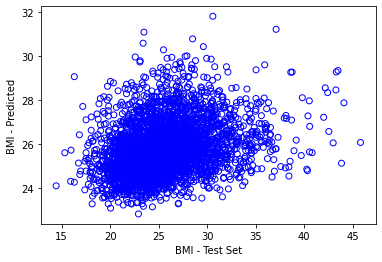

In [ ]:
plt.scatter(Y_test,Y_pred, c='', edgecolors="b")
plt.xlabel('BMI - Test Set')
plt.ylabel('BMI - Predicted')

How strong is the linear relationship that is displayed in the scatterplot?


In [ ]:
np.corrcoef(Y_test,Y_pred)[0, 1]

0.277431782494455

There are several other parameters that we can calculate to examine the model.

#### Percent Error - measures the difference between estimated and actual values

Text(0, 0.5, 'Frequency')

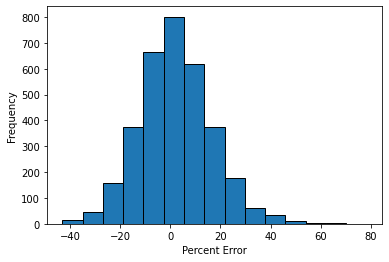

In [ ]:
percent_error = (Y_pred-Y_test) / Y_test * 100;
plt.hist(percent_error,15, edgecolor="black")
plt.xlabel('Percent Error')
plt.ylabel('Frequency')

#### Percent Average Error


In [ ]:
percent_avg_error = np.mean(np.abs(percent_error))
percent_avg_error

11.33594473328995

Root Mean Square Error (RMSE) - measures the standard deviation of the residuals


In [ ]:
RMSE = np.sqrt(mean_squared_error(Y_pred, Y_test))
RMSE

3.790671768536864

RMSE is sensitive to large errors because the squaring process gives disproportionate weight to very large errors. Further, the RMSE can only be compared between models whose errors are measured in the same units. There is no absolute criterion for a "good" value of RMSE; it depends on the units in which the variable is measured and on the degree of predictive accuracy.

### Testing Using Cross Validation

We will now repeat the previous analysis using five fold cross validation. For this analysis, the data set will be broken into five groups of equal size, called folds. We will train the model wth 80% of the data set and test the model with the remaining 20%. This process will be repeated five times so that a model is created for each test set. 

Note that if there is any sort of ordering to the data, we cannot simply split the first 80% into the training set and the last 20% into the test set. It is better to populate the training and test sets by randomly ordering or shuffling the data set first. There are a number of ways to randomize data in MATLAB. One method is shown below:

In [ ]:
indices = np.arange(fram_noNaN.shape[0])
np.random.shuffle(indices)

shuffled = fram_noNaN.values[indices,:]
shuffled

array([[ 58.  ,   1.  ,  76.  , 204.  , 106.  ,  18.3 ],
       [ 65.  ,   2.  , 366.  , 308.  , 127.5 ,  28.82],
       [ 43.  ,   1.  ,  74.  , 285.  , 129.  ,  26.64],
       ...,
       [ 73.  ,   2.  ,  83.  , 276.  , 113.  ,  20.07],
       [ 62.  ,   2.  ,  73.  , 294.  , 121.  ,  26.98],
       [ 34.  ,   2.  ,  82.  , 196.  , 108.5 ,  25.67]])

There are several functions in `sklearn` built for generating training and test sets, and they often shuffle the data internally. One of these functions is crossvalind. The function requires inputs for the cross validation method ('kfold' in our case), the number of observations, and the number of folds (k). The output contains a randomized array of indices (varying from 1 to k) which are assigned to each row in the data set and create folds of approximately equal size.

Create an array which contains randomized indices for all of the rows in our data set.

In [ ]:
kf = KFold(shuffle=True)
splits = kf.split(X)

for i, (train_split, test_split) in enumerate(splits):
  print("Split Number "+str(i+1)+".: training set size " + str(train_split.shape[0]) + ", testing set size " + str(test_split.shape[0]))
  

Split Number 1.: training set size 8016, testing set size 2005
Split Number 2.: training set size 8017, testing set size 2004
Split Number 3.: training set size 8017, testing set size 2004
Split Number 4.: training set size 8017, testing set size 2004
Split Number 5.: training set size 8017, testing set size 2004


It is clearly that it returns a list containing 5 pairs of datasets. For each pair of datasets, it contains a training dataset and a testing dataset. The whole dataset is split into 5 kolds. And for each pair, the training dataset contains 4 folds and the testing dataset contains 1 fold. Also, we cna see all folds are approximately the same size.

In [ ]:
RMSE_kfold = np.zeros((5))
corr_kfold = np.zeros((5))
avg_error = np.zeros((5))
RMSE_kfold, corr_kfold, avg_error

(array([0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0.]))

In [ ]:
kf = KFold(shuffle=True)
splits = kf.split(X)
for i, (train_indices, test_indices) in enumerate(list(splits)):
  # print(str(train_split.shape[0]))
  X_train = X[train_indices,:]    
  Y_train = Y[train_indices]   
  X_train_ = add_constant(X_train)
  model = sm.OLS(Y_train, X_train_)
  est = model.fit()
  #Extract test rows from X and Y 
  X_test = X[test_indices,:]   
  Y_test = Y[test_indices]   
  X_test_ = add_constant(X_test)

  # Predict Y values from model. Calculate stat parameters and assign
  # to index i of variables
  Y_pred = est.predict(X_test_)   
  corr_kfold[i] = np.corrcoef(Y_test,Y_pred)[0,1]   
  RMSE_kfold[i] = np.sqrt(mean_squared_error(Y_pred, Y_test))
  avg_error[i] = np.mean(np.abs(Y_pred - Y_test)/Y_test*100)

np.mean(corr_kfold), np.mean(RMSE_kfold), np.mean(avg_error)

(0.29141657047631286, 3.8627250149883494, 11.400493189123099)

## Evaluating discrete data sets using hold out validation

Similar methods can be used to evaluate discrete data sets, where the data can only take on certain values. An example would be classifying patients with diabetes versus those without diabetes. The values can only be one of two numbers: 0 (non-diabetic) or 1 (diabetic).
How well can we predict diabetes from the patients' glucose levels? Since we are using the hold out method, we can incorporate the `trainTestSplit` function again. This time, create a training set with 80% of the data set. 

In [ ]:
fram_discrete = pd.concat([fram.GLUCOSE, fram.DIABETES], axis=1).dropna()
gluc = fram_discrete.GLUCOSE.to_numpy().reshape(-1, 1)
diab = fram_discrete.DIABETES.to_numpy()
X_train, Y_train, X_test, Y_test = trainTestSplit(gluc,diab,0.8);
X_train, Y_train, X_test, Y_test

(array([[ 76.],
        [ 83.],
        [ 82.],
        ...,
        [100.],
        [ 94.],
        [ 71.]]), array([0, 0, 0, ..., 0, 0, 0]), array([[ 73.],
        [ 83.],
        [ 73.],
        ...,
        [ 87.],
        [ 80.],
        [101.]]), array([0, 0, 0, ..., 1, 0, 0]))

Recall from last lecture that we used the mnrfit function for analyzing discrete categorical data.  

The `Y_train` variable contains two categories: non-diabetic (0) and diabetic (1). The last category, in this case diabetic, is always used as the reference category for the mnrfit function. The logistic regression model will tell us the relative log odds of being non-diabetic versus diabetic. Create the model using `X_train` and `Y_train` and then print the regression coefficients. 


In [ ]:
X_train_ = add_constant(X_train)

model = sm.MNLogit(Y_train, X_train_)
model_fit = model.fit()
print(model_fit.summary())

Optimization terminated successfully.
         Current function value: 0.112151
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                 8150
Model:                        MNLogit   Df Residuals:                     8148
Method:                           MLE   Df Model:                            1
Date:                Thu, 06 May 2021   Pseudo R-squ.:                  0.3531
Time:                        19:00:20   Log-Likelihood:                -914.03
converged:                       True   LL-Null:                       -1412.9
Covariance Type:            nonrobust   LLR p-value:                5.399e-219
       y=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.8045      0.273    -32.210      0.000      -9.340      -8.269
x1             0.0586      0.

The first term in b is the intercept term of the relative risk model and the second term is the coefficient for glucose levels. The resulting equation is: 

$$\ln (\frac{\pi_{diabetic}}{\pi_{normal}})=-8.6959+0.0579X_1$$

The relative log odds of being non-diabetic versus diabetic decreases 0.0565 times with a one-unit increase in $X_1$, assuming all else is equal. Here $X_1$ is our only predictor variable, glucose. While this does not seem like a strong relationship, the model makes sense. Diabetic patients typically have higher glucose levels, so for every unit increase in glucose, there is a lesser chance that the patient is non-diabetic. 

The `MNLogit` function also outputs several other statistical parameters, such as the p-value for each of the mdoel parameters.

The p-value for glucose is magnitudes below the accepted value of 0.05, meaning the measure of glucose levels is significant to the relative risk of being non-diabetic versus diabetic. 

## Estimating model accuracy in test data
The model accuracy can be evaluated using the test sets that we created, along with the `predict` function. Recall that this function returns the predicted probabilities for the logistic regression model given certain values for the predictor variables, which come from the predictor test set.


In [ ]:
probability = model_fit.predict(add_constant(X_test))
probability[:5, : ]

array([[0.98930479, 0.01069521],
       [0.98094661, 0.01905339],
       [0.98930479, 0.01069521],
       [0.98201143, 0.01798857],
       [0.95774934, 0.04225066]])

The left column shows the probability, based on our model, that the patient is non-diabetic. The right colum shows the probabilty that they are diabetic. 

In order to compare the predicted values to the test values, round the predicted values to the nearest integer (0 or 1). The model accuracy can then be determined by checking how many rows in the predicted and test sets match. We want to use the second column from the probability matrix because in that case, a 0 will indicate non-diabetic and 1 will indicate diabetic, which is the same system as the test data set.

In [ ]:
Y_pred_round = np.round(probability);
accuracy = sum(Y_pred_round[:,1] == Y_test)/ Y_pred_round.shape[0]
# Y_pred_round
accuracy

0.9597447226313206

## Hold out validation with multiple predictors

We will now repeat the hold out validation test, but this time we will use BMI, glucose and cholesterol to predict diabetes. What is the equation for this model and which variable has the greatest effect on predicting BMI? Also, which variables are statistically significant?

In [ ]:
fram_discrete_2 = pd.concat([fram.GLUCOSE, fram.BMI, fram.TOTCHOL, fram.DIABETES], axis=1).dropna().values
X = fram_discrete_2[:,:-1]
Y = fram_discrete_2[:,-1]
[X_train, Y_train, X_test, Y_test] = trainTestSplit(X,Y,0.8);
# Ytrain = categorical(Ytrain);
model = sm.MNLogit(Y_train, add_constant(X_train))
model_fit = model.fit()
model_fit.summary()

Optimization terminated successfully.
         Current function value: 0.113179
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                 8017
Model:                        MNLogit   Df Residuals:                     8013
Method:                           MLE   Df Model:                            3
Date:                Thu, 06 May 2021   Pseudo R-squ.:                  0.3480
Time:                        19:00:20   Log-Likelihood:                -907.36
converged:                       True   LL-Null:                       -1391.6
Covariance Type:            nonrobust   LLR p-value:                1.250e-209
==============================================================================
       y=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.8023      0.583    -18.542      0.000     -11.944      -9.660
x1             0.0563      0.003     22.302      0.000       0.051       0.061
x2             0.0687      0.014      4.801      0.000       0.041       0.097
x3             0.0017      0.001      1.189      0.234      -0.001       0.004
==============================================================================
"""

Based on the results, the model's equation should look similar to this:  
$$\ln (\frac{\pi_{diabetic}}{\pi_{normal}})=-10.8911+0.0579X_1+0.0718X_2+0.0012X_3$$

Our model suggests that BMI has the greatest impact towards being diabetic or non-diabetic. Based on the p-values, we would reject the null hypothesis for glucose and BMI, and fail to reject for total cholesterol. 

Next, find the accuracy of the model.


In [ ]:
probability = model_fit.predict(add_constant(X_test))
Y_pred_round = np.round(probability);
Y_pred_round = np.round(probability);
accuracy = sum(Y_pred_round[:,1] == Y_test)/ Y_pred_round.shape[0]
# Y_pred_round
accuracy

0.968562874251497

## Example: 10 fold cross validation
We will now use 10 fold cross validation to evaluate our model for diabetes using glucose, BMI and cholesterol. A for loop similar to the one used in the previous example can be used. 

In [ ]:
b = np.zeros((10, 4))
p_values = np.zeros((10, 4))
accuracy = np.zeros((10))
kf = KFold(shuffle=True, n_splits=10)
splits = kf.split(X)
for i, (train_indices, test_indices) in enumerate(list(splits)):
  X_train = X[train_indices,:]    
  Y_train = Y[train_indices]   
  X_train_ = add_constant(X_train)
  model = sm.MNLogit(Y_train, X_train_)
  est = model.fit()
  #Extract test rows from X and Y 
  X_test = X[test_indices,:]   
  Y_test = Y[test_indices]   
  X_test_ = add_constant(X_test)

  # Predict Y values from model. Calculate stat parameters and assign
  # to index i of variables
  Y_pred = est.predict(X_test_)   

  p_values[i, :] = est.pvalues.reshape(-1)
  b[i, :] = est.params.reshape(-1)

  Y_pred_round = np.round(Y_pred)
  accuracy[i] = sum(Y_pred_round[:,1] == Y_test)/ Y_pred_round.shape[0]
  


Optimization terminated successfully.
         Current function value: 0.111279
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.113891
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.113307
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.114610
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.116105
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.111632
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.119116
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.113830
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.112980
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.114378
  

In [ ]:
np.mean(b, axis=0)

array([-1.06040602e+01,  5.66868790e-02,  6.69928678e-02,  9.42923244e-04])

In [ ]:
np.mean(p_values, axis=0)

array([2.21491486e-077, 1.69805093e-123, 2.65792634e-006, 5.06963250e-001])

In [ ]:
np.mean(accuracy)

0.9702631626079846

We now have a model with the equation of 

$$\ln (\frac{\pi_{diabetic}}{\pi_{normal}})=-10.6028+0.0567X_1+0.0670X_2+0.0094X_3$$

Once again, the p-values indicate that glucose and BMI are significant to the model, but total cholesterol is not.

## Additional metrics to evaluate accuracy

Confusion matrices are useful tools for evaluating how well a classification model performs. We use heatmap to represnet a confusion chart. It can visualize

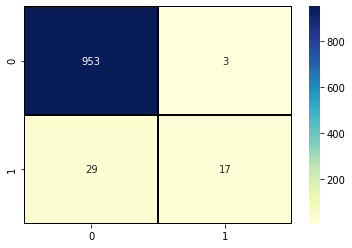

In [ ]:
cm = confusion_matrix(Y_test, Y_pred_round[:, 1])
df = pd.DataFrame(cm)
sns.heatmap(df, cmap="YlGnBu", annot=True, fmt="d", linewidths=1, linecolor="black")

There are four sections in the confusion matrix:

1. **True positive (TP)** - the model predicts TRUE and the actual outcome is TRUE 
2. **True negative (TN)** - the model predicts FALSE and the actual outcome is FALSE 
3. **False positive (FP)** - the model predicts TRUE and the actual outcome is FALSE 
4. **False negative (FN)** - the model predicts FALSE and the actual outcome is TRUE 

Using the values in the confusion matrix or the model variables (Ypred and Ytest), calculate the following parameters:
- **Precision** - the number of times that the model correctly predicted diabetes over the total number of times that the model predicted diabetes.



In [ ]:
precision = np.sum((Y_pred_round[:, 1]==1) & (Y_test==1))/np.sum(Y_pred_round[:, 1]==1)
precision
# Y_pred_round[:, 1]==1

0.85

This is equivalent to the following calculation from the confusion matrix: 

$$\frac{14}{14+4}=0.7778$$

- **Recall** - the number of times the model correctly predicted diabetes over the total number of diabetes cases in the test set. 


In [ ]:
recall = sum((Y_pred_round[:, 1]==1) & (Y_test==1))/sum(Y_test==1)
recall
# sum((Y_pred_round[:, 1]==1) & (Y_test==1)), sum(Y_test==1)

0.3695652173913043

This is equivalent to the following calculation from the confusion matrix: 
$$\frac{14}{14+24}=0.368$$

## Outcome: model testing and validation
Errors arise due to both bad <u>data</u> and bad <u>models</u>

Need to have the right benchmark i.e. what accuracy is good enough?

**Overfitting** - model is too complex
- Solution: simplify the model, get more training data, reduce noise in the data
**Underfitting** - model is too simple
- Solution: add more features to the model, use more complex algorithms
**Confounding variables** - some features are irrelevant
 - Solution: start with a strong hypothesis, use unsupervised learning methods to find relevant features,                                 
 make sure the training data has appropriate features and sample size

A problem can arise when you measure the generalization error multiple times on the test set, and then adapt the model and hyperparameters to produce the best model for that set. This means that the model is unlikely to perform as well on new data. A common solution to this problem is to have a second holdout set called the **validation set**, which is used to run a single final test against the test set to get an estimate of the generalization error. 

## Improving data quality by normalization

- Most machine learning algorithms calculate the distance between two data points.
- The range of numeric values can be different between the various feature variables. For example, in the Framingham data set, BMI has a larger value and range than Sex or Education.
- Euclidean distance will be skewed by magnitude and range.
- The range of all features should be normalized so that each feature contributes equally to the distance.
- Scaling and normalization allows us to compare features at the same scale.

## Re-scaling Framingham data set

Re-scaling data can help improve your linear regression model. If the explanatory variables are very different in their magnitudes, it can be difficult to interpret the model coefficients. In the Framingham data set, for example, Age ranges from 32 to 81, while Total Cholesterol ranges from 107 to 696. This difference in magnitude may exaggerate the effect of Total Cholesterol in the model. 
One method for scaling the data is to set all of the predictor means to zero. To do this, the variable's mean is subtracted from each data point and then divided by the standard deviation. 
$$z=\frac{x-\mu}{\sigma}$$
The scipy function `zscore` does these calculations for you.

Example: plot normalized BMI vs Glucose


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Normalized Glucose')

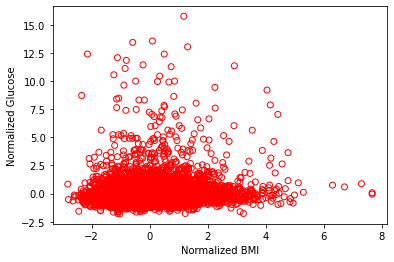

In [ ]:
BMI_norm = zscore(fram_noNaN.BMI.to_numpy());
gluc_norm = zscore(fram_noNaN.GLUCOSE.to_numpy());
plt.scatter(BMI_norm,gluc_norm, c = "", edgecolors="r")
plt.xlabel('Normalized BMI')
plt.ylabel('Normalized Glucose')


We can use `numpy.linalg.norm` function outputs the Euclidean distance between pairs of observations. We can use this function to see the effects of normalization. Compare the average distance between the BMI and glucose data points before and after normalization.


In [ ]:
X = np.array([fram_noNaN.BMI.values,fram_noNaN.GLUCOSE.values]).T
Y1 = np.mean(pdist(X))
Y1

21.526842231079602

In [ ]:
X = np.array([BMI_norm, gluc_norm]).T
Y2 = np.mean(pdist(X))
Y2

1.532236636902887


We will now revisit our original model which used age, sex, glucose, total cholesterol and systolic blood pressure to predict BMI. Use gplotmatrix to create a `scatter_matrix` matrix of these normalized variables.

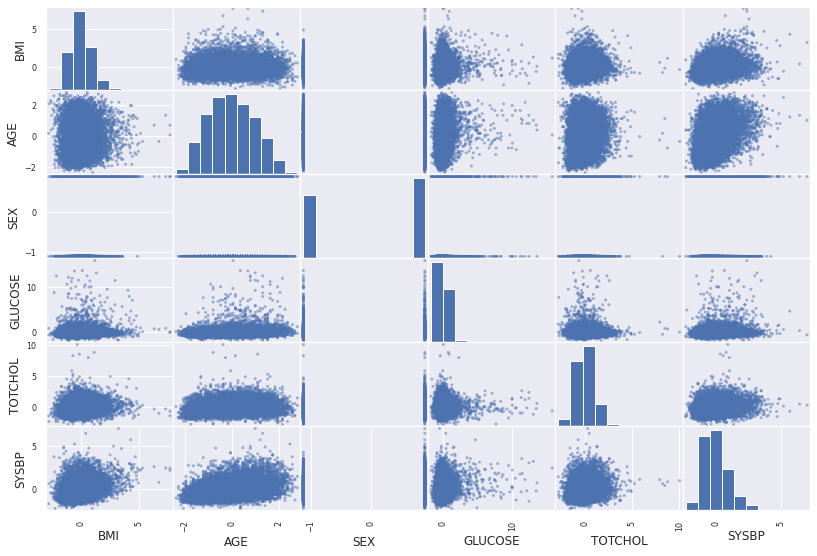

In [ ]:
columns = ['BMI','AGE','SEX','GLUCOSE','TOTCHOL','SYSBP']
df = fram_noNaN.loc[:,columns]
values = zscore(df.values)
df2 = pd.DataFrame(values, columns=columns)
sns.set(rc={'figure.figsize':(13.7,9.27)})
pd.plotting.scatter_matrix(df2)
plt.show()

Create a model using the scaled features and compare the regression coefficient values to those of the original model (BMI_model).

In [ ]:
X_norm = values[:,1:]
Y_norm = values[:,0]
X_norm_ = add_constant(X_norm)

model = sm.OLS(Y_norm, X_norm_)
est = model.fit()
est.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     189.6
Date:                Thu, 06 May 2021   Prob (F-statistic):          1.53e-193
Time:                        19:00:26   Log-Likelihood:                -13766.
No. Observations:               10021   AIC:                         2.754e+04
Df Residuals:                   10015   BIC:                         2.759e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.042e-16      0.010  -7.37e-14      1.000      -0.019       0.019
x1            -0.0636      0.010     -6.076      0.000      -0.084      -0.043
x2            -0.0948      0.010     -9.822      0.000      -0.114      -0.076
x3             0.0481      0.010      4.952      0.000       0.029       0.067
x4             0.0592      0.010      6.028      0.000       0.040       0.078
x5             0.2788      0.010     26.634      0.000       0.258       0.299
==============================================================================
Omnibus:                     1615.012   Durbin-Watson:                   1.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4166.410
Skew:                           0.892   Prob(JB):                         0.00
Kurtosis:                       5.607   Cond. No.                         1.60
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
BMI_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     189.6
Date:                Thu, 06 May 2021   Prob (F-statistic):          1.53e-193
Time:                        19:03:39   Log-Likelihood:                -27755.
No. Observations:               10021   AIC:                         5.552e+04
Df Residuals:                   10015   BIC:                         5.557e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.8170      0.340     58.290      0.000      19.151      20.483
x1            -0.0270      0.004     -6.076      0.000      -0.036      -0.018
x2            -0.7705      0.078     -9.822      0.000      -0.924      -0.617
x3             0.0078      0.002      4.952      0.000       0.005       0.011
x4             0.0053      0.001      6.028      0.000       0.004       0.007
x5             0.0497      0.002     26.634      0.000       0.046       0.053
==============================================================================
Omnibus:                     1615.012   Durbin-Watson:                   1.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4166.410
Skew:                           0.892   Prob(JB):                         0.00
Kurtosis:                       5.607   Cond. No.                     2.63e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The two models have the following equations:

*Before normalization:*

$$Y=19.817-0.027AGE-0.77SEX+0.0078GLUC+0.053TOTCHOL+0.0497SYSBP$$

*After normalization:*

$$Y=-0.0636AGE-0.0948SEX+0.0481GLUC+0.0592TOTCHOL+0.2788SYSBP$$
